In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
df = pd.read_excel('Forecasting_data.xlsx', parse_dates=['Date'], index_col='Date')
df.ffill(inplace=True)  # Handle missing values


In [3]:
y = df['Revenue']
X = df[['spend_meta', 'spend_google', 'spend_youtube', 'spend_tiktok',
        'impressions_tiktok', 'impressions_youtube', 'impressions_snapchat']]

In [4]:
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


In [5]:
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [6]:
sarima_order = (1, 1, 1)
sarima_seasonal_order = (1, 1, 1, 4) 

sarima_model = SARIMAX(y_train_scaled.flatten(),
                      exog=X_train_scaled,
                      order=sarima_order,
                      seasonal_order=sarima_seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)

sarima_result = sarima_model.fit(disp=False, maxiter=200)
sarima_forecast_scaled = sarima_result.get_forecast(steps=len(y_test), exog=X_test_scaled)
sarima_forecast = scaler_y.inverse_transform(sarima_forecast_scaled.predicted_mean.reshape(-1, 1))


In [7]:
def create_dataset(X, y, time_steps=4):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 4
X_train_ts, y_train_ts = create_dataset(X_train_scaled, y_train_scaled, time_steps)
X_test_ts, y_test_ts = create_dataset(X_test_scaled, y_test_scaled, time_steps)


In [8]:
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(time_steps, X_train_scaled.shape[1])),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(X_train_ts, y_train_ts,
                        epochs=100,
                        batch_size=16,
                        validation_split=0.1,
                        callbacks=[early_stop],
                        verbose=0)

lstm_forecast_scaled = lstm_model.predict(X_test_ts)
lstm_forecast = scaler_y.inverse_transform(lstm_forecast_scaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


In [9]:
def evaluate_model(name, actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    r2 = r2_score(actual, forecast)
    print(f'{name} MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}')
    return mae, rmse, r2

sarima_metrics = evaluate_model('SARIMA', y_test, sarima_forecast)
lstm_metrics = evaluate_model('LSTM', y_test[:-time_steps], lstm_forecast)  # Align lengths

SARIMA MAE: 21.81, RMSE: 27.78, R²: 0.55
LSTM MAE: 29.93, RMSE: 37.13, R²: 0.20


In [10]:
future_weeks = 52
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_weeks+1, freq='W')[1:]


In [11]:
future_X = scaler_X.transform(X.iloc[-future_weeks:])


In [12]:
sarima_future = sarima_result.get_forecast(steps=future_weeks, exog=future_X)
sarima_future_values = scaler_y.inverse_transform(sarima_future.predicted_mean.reshape(-1, 1))

In [13]:
X_future = X_test_scaled[-time_steps:].reshape(1, time_steps, -1)
lstm_future = []
for _ in range(future_weeks):
    pred = lstm_model.predict(X_future, verbose=0)
    lstm_future.append(pred[0, 0])
    X_future = np.roll(X_future, -1, axis=1)
    X_future[0, -1, :] = scaler_X.transform(X.iloc[-future_weeks + _].values.reshape(1, -1))

lstm_future = scaler_y.inverse_transform(np.array(lstm_future).reshape(-1, 1))

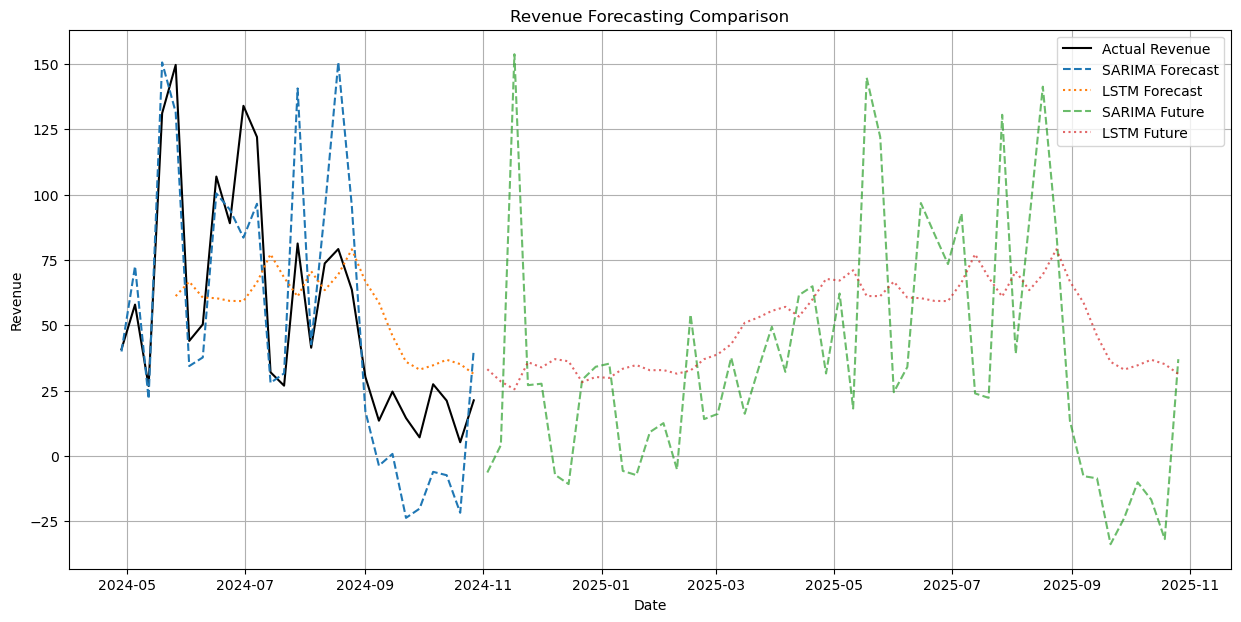

In [14]:
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual Revenue', color='black')
plt.plot(y_test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--')
plt.plot(y_test.index[time_steps:], lstm_forecast, label='LSTM Forecast', linestyle=':')
plt.plot(future_dates, sarima_future_values, label='SARIMA Future', linestyle='--', alpha=0.7)
plt.plot(future_dates, lstm_future, label='LSTM Future', linestyle=':', alpha=0.7)
plt.title('Revenue Forecasting Comparison')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

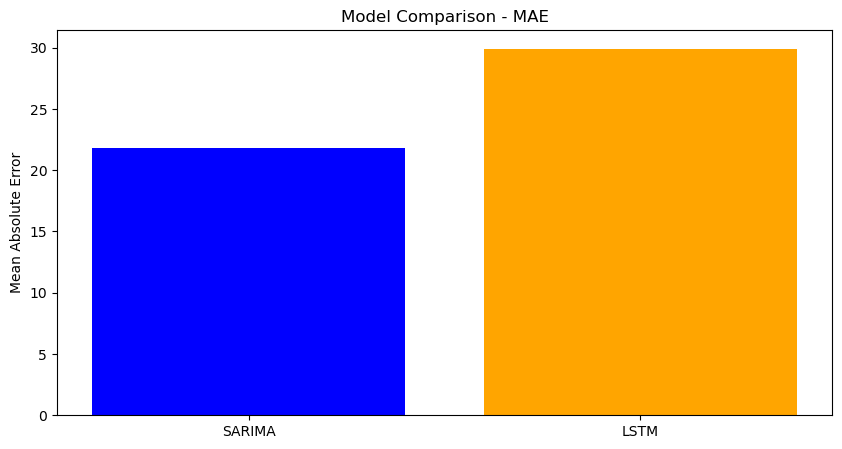

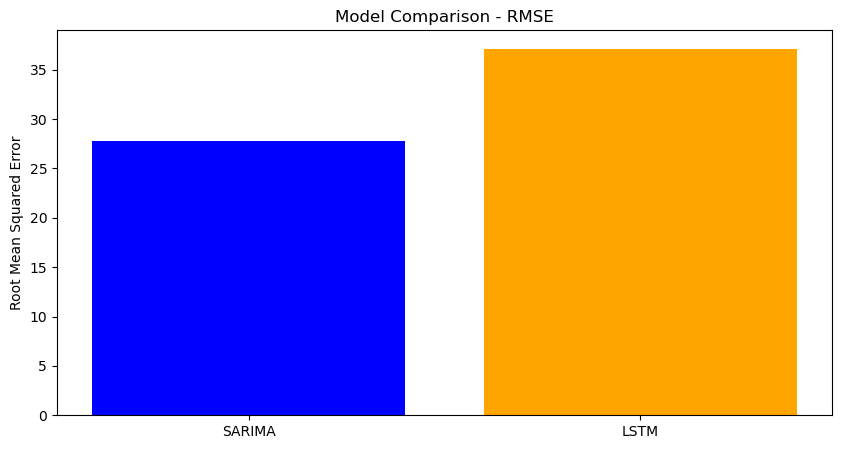

In [15]:
models = ['SARIMA', 'LSTM']
mae_values = [sarima_metrics[0], lstm_metrics[0]]
rmse_values = [sarima_metrics[1], lstm_metrics[1]]

plt.figure(figsize=(10, 5))
plt.bar(models, mae_values, color=['blue', 'orange'])
plt.title('Model Comparison - MAE')
plt.ylabel('Mean Absolute Error')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(models, rmse_values, color=['blue', 'orange'])
plt.title('Model Comparison - RMSE')
plt.ylabel('Root Mean Squared Error')
plt.show()